In [1]:
import numpy as np
import torch
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint


import matplotlib.pyplot as plt
import matplotlib.animation as animation


#1. generating rotating covariance dataset:

In [55]:
N_train = 10000
N_val = 1000
N_test = 1000

w = 20 # discretisation size
theta = np.pi/w # angle discretisation
rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

X_train = np.random.uniform(0, np.pi, size=(N_train))
X_val = np.random.uniform(0, np.pi, size=(N_val))
X_test = np.random.uniform(0, np.pi, size=(N_test))

cov_t0 = np.array([[2, 0], [0, 0.5]])
mean = np.array([0,0])

def compute_y(X):
    y = np.zeros((X.shape[0], 2))
    for i, xi in enumerate(X):
        n_rot = int(xi//theta)
        rot = np.linalg.matrix_power(rotation, n_rot)
        y[i] = np.random.multivariate_normal(mean, rot@cov_t0)
    return y

Y_train = compute_y(X_train)
Y_val = compute_y(X_val)
Y_test = compute_y(X_test)

C:\Users\Grégoire\AppData\Local\Temp\ipykernel_10312\1122875652.py:21: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y[i] = np.random.multivariate_normal(mean, rot@cov_t0)


In [ ]:
def cov_to_ellipse(cov, T):
    eig_val, eig_vec = np.linalg.eigh(cov)
    eig_val = np.sqrt(eig_val)
    
    xy = np.stack((np.cos(T), np.sin(T)), axis=-1)

    return eig_vec @ (eig_val * xy).T

C:\Users\Grégoire\AppData\Local\Temp\ipykernel_10312\2261629245.py:26: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, updatefig,  blit=False)
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


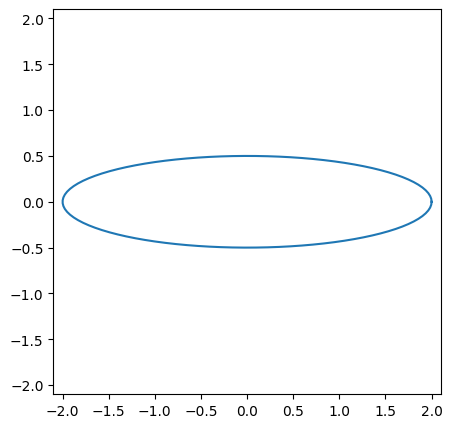

In [56]:
# animation of the covariance:

X_sorted = np.argsort(X_train)
bins = X_sorted//theta

fig = plt.figure(figsize=(5,5))
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
i=1
im1 = plt.scatter(Y_train[bins==1][:,0], Y_train[bins==1][:,1])
T = np.linspace(0, 2*np.pi, 100)
im2, = plt.plot(*cov_to_ellipse(cov_t0, T))
def updatefig(*args):
    global i
    if (i<=np.max(bins)):
        i += 1
    else:
        i=1
    vals = (bins == i)
    rot = np.linalg.matrix_power(rotation, i)
    im1.set_offsets(Y_train[vals])
    im2.set_data(cov_to_ellipse(cov_t0)@rot)
    return im1
ani = animation.FuncAnimation(fig, updatefig,  blit=False)
plt.show()

In [57]:
X_train_torch = frnp(X_train.reshape((-1, 1)))
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val.reshape((-1, 1)))
Y_val_torch = frnp(Y_val)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


In [58]:
# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

L.seed_everything(0)

gamma = 2e-2
epochs = int(5e3)
output_shape = 100

MLP_kwargs_U = {
    'input_shape': X_train_torch.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': [32, 64, 128],
    'dropout': 0.,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

MLP_kwargs_V = {
    'input_shape': Y_train_torch.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size':[8, 16, 32],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': torch.nn.ReLU
}

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s, v_num=41, val_loss=0.00168, train_loss=-0.00267]  


Compute conditional covariance by convolution with gaussian kernel

Cov(Y |X ∈ A) = Cov(Y ) + ⟨1A, [(1dy ⊗ 1dy ) ⊗ DY |X ]h ⊗ h⟩/P[X ∈ A]
− ⟨1A, [1dy ⊗ DY |X ]h⟩ ⊗ ⟨1A, [1dy ⊗ DY |X ]h⟩/(P[X ∈ A])2

In [51]:
from sklearn.gaussian_process.kernels import RBF

def compute_covariance(model, X0, x_discr, y_discr, h=0.1):
    #only works for 2D data
    kernel = RBF(length_scale=h)([X0], x_discr).flatten()
    kernel /= np.sum(kernel)

    eyx = model.conditional_expectation(x_discr, y_discr, postprocess='whitening')
    ey2x = model.conditional_expectation(x_discr, y_discr, observable=torch.square, postprocess='whitening')
    cross = lambda x: (x[:,1]*x[:,0]).unsqueeze(1)
    eycrossx = model.conditional_expectation(x_discr, y_discr, observable=cross, postprocess='whitening')

    eyx = np.sum(eyx*np.tile(kernel, ( y_discr.shape[-1], 1)).T, axis=0)
    ey2x = np.sum(ey2x*np.tile(kernel, ( y_discr.shape[-1], 1)).T,axis=0)
    eycrossx = np.sum(eycrossx*kernel)
    centered_cov = np.eye(2) * ey2x + (1-np.eye(2))*eycrossx

    cross_expectation= np.outer(eyx.T, eyx)

    return centered_cov - cross_expectation

In [59]:
compute_covariance(best_model, 0.5, np.linspace(0,1,100).reshape((-1,1)), Y_train_torch)

[[ 2.21095102 -3.04253172]
 [-3.04253172  0.53767581]]
[[5.41868415e-03 8.11953491e-05]
 [8.11953491e-05 1.21665787e-06]]


array([[ 2.20553234, -3.04261292],
       [-3.04261292,  0.53767459]])